# Tune In: Decision Threshold Optimization with scikit-learn's TunedThresholdClassifier

The 1.5.0 release of scikit-learn includes a new class, TunedThresholdClassifier, that makes optimizing decision thresholds from scikit-learn classifiers easier. A decision threshold is a cut-off point that converts predicted probabilities output by a machine learning model into discrete classes. The default decision threshold of the predict method from scikit-learn classifiers is 0.5. Although this is a sensible default, it is rarely the best choice for classification tasks.¹²
This new scikit-learn class will help bridge the gap between data scientists who build models and business stakeholders who make decisions based on the model's output. Data scientists should add this step to their machine learning workflow to better communicate their model performance with those stakeholders. In this post, you will learn three ways to use TunedThresholdClassifier to optimize decision thresholds:

1. Tuning under constraints: When optimizing the operating point on the ROC or precision-recall curve.
2. Maximizing a metric: When choosing a threshold that maximizes a metric, like balanced accuracy or a custom metric.
3. Cost-sensitive learning: When the cost of misclassifying a false positive is not equal to the cost of misclassifying a false negative.

## Tuning under constraints  
The tuning under constraint method finds a decision threshold by identifying a point on either the ROC or precision-recall curves. The point on the curve is the maximum value of one axis while constraining the other axis. This logic is implemented when the argument for the objective_metric parameter of TunedThresholdClassifier is one of the following:
* max_tpr_at_tnr_constraint
* max_tnr_at_tpr_constraint
* max_precision_at_recall_constraint
* max_recall_at_precision_constraint

For this tutorial, we'll be using the Pima Indians diabetes dataset. This is a binary classification task to predict if an individual has diabetes. Imagine that your model will be used as a screening test for an average-risk population applied to millions of people. There are an estimated 38 million people with diabetes in the US. This is roughly 11.6% of the population, so the model's specificity should be high so it doesn't misdiagnose millions of people with diabetes and refer them to unnecessary confirmatory testing.
Suppose your imaginary CEO has communicated that they will not tolerate more than a 2% false positive rate. Let's build a model that achieves this using TunedThresholdClassifier. First, import the necessary libraries, read the data, and split training and test data.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, f1_score, recall_score, roc_curve
from sklearn.model_selection import TunedThresholdClassifier, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("data/diabetes.csv")

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=["Outcome"]), data["Outcome"], test_size=0.2
)

Build two models, one logistic regression to serve as a baseline model and the other, TunedThresholdClassifier which will wrap the baseline logistic regression model, to achieve the goal outlined by the CEO. In the tuned model, set the objective_metric to "max_tpr_at_tnr_constraint" and impose a constraint of 98% true negative rate (or 2% false positive rate). *The choice of preprocessing and model type is not essential for this tutorial.*

In [3]:
# A baseline model
original_model = make_pipeline(StandardScaler(), LogisticRegression())
original_model.fit(X_train, y_train)

# A tuned model
tuned_model = TunedThresholdClassifier(
    original_model,
    objective_metric="max_tpr_at_tnr_constraint",
    constraint_value=0.98,
)
tuned_model.fit(X_train, y_train)

# Check that the coefficients from the original model and the tuned model are the same
assert (tuned_model.estimator_[-1].coef_ == original_model[-1].coef_).all()

The underlying models are the same, evidenced by the coefficient equality in the assert statement above. Optimization in TunedThresholdClassifier is achieved using post-processing techniques, which are applied directly to the predicted probabilities output by the model. In other words, optimization occurs independently of the model training. However, it's important to note that TunedThresholdClassifier uses cross-validation by default to find the decision threshold.

Compare the difference between the default decision threshold from scikit-learn estimators, 0.5, and one found using the tuning under constraint approach on the ROC curve.

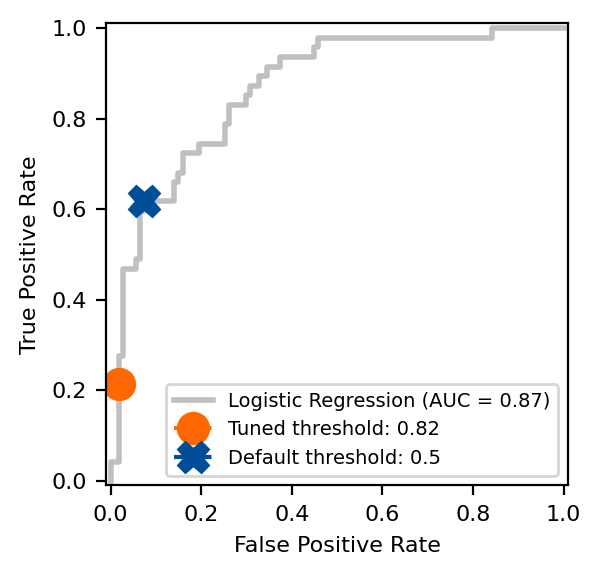

In [4]:
# Get the fpr and tpr of the original model
original_model_proba = original_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, original_model_proba)
fpr_orig = fpr[(np.abs(thresholds - 0.5)).argmin()]
tpr_orig = tpr[(np.abs(thresholds - 0.5)).argmin()]

# Get the tnr and tpr of the tuned model
max_tpr = tuned_model.best_score_
constrained_tnr = tuned_model.constrained_score_

# Plot the ROC curve and compare the default threshold to the tuned threshold
fig, ax = plt.subplots(figsize=(3, 3))
# Note that this will be the same for both models
disp = RocCurveDisplay.from_estimator(
    original_model,
    X_test,
    y_test,
    name="Logistic Regression",
    color="#c0c0c0",
    linewidth=2,
    ax=ax,
)
disp.ax_.plot(
    1 - constrained_tnr,
    max_tpr,
    label=f"Tuned threshold: {tuned_model.best_threshold_:.2f}",
    color="#ff6700",
    linestyle="--",
    marker="o",
    markersize=11,
)
disp.ax_.plot(
    fpr_orig,
    tpr_orig,
    label="Default threshold: 0.5",
    color="#004e98",
    linestyle="--",
    marker="X",
    markersize=11,
)
disp.ax_.set_ylabel("True Positive Rate", fontsize=8)
disp.ax_.set_xlabel("False Positive Rate", fontsize=8)
disp.ax_.tick_params(labelsize=8)
disp.ax_.legend(fontsize=7)

The tuned under constraint method found a threshold of 0.815 that showed an average specificity of 98% and an average sensitivity of 21.4% during cross-validation on the training data. See how the threshold holds up in the test set.

In [5]:
# Average sensitivity and specificity on the training set
avg_specificity_train, avg_sensitivity_train = tuned_model.constrained_score_, tuned_model.best_score_

# Call predict from tuned_model to calculate sensitivity and specificity on the test set
specificity_test = recall_score(
    y_test, tuned_model.predict(X_test), pos_label=0)
sensitivity_test = recall_score(y_test, tuned_model.predict(X_test))

print(f"Average sensitivity on the training set: {avg_sensitivity_train:.3f}")
print(f"Average specificity on the training set: {avg_specificity_train:.3f}")
print(f"Sensitivity on the test set: {sensitivity_test:.3f}")
print(f"Specificity on the test set: {specificity_test:.3f}")

Average sensitivity on the training set: 0.214
Average specificity on the training set: 0.981
Sensitivity on the test set: 0.191
Specificity on the test set: 0.981


## Maximizing a metric
Now, consider a scenario where your test is given to individuals from a population at high risk for diabetes diagnosis. Assume the disease prevalence is triple the average rate in this population, roughly 33%. In this scenario, the CEO wants you to maximize the F1 score to balance precision and recall.

The method used to maximize a metric is more straightforward than the tuned under constraint approach. Use any scikit-learn metric as the argument for the objective_metric parameter, and the TunedThresholdClassifier will find the decision threshold that maximizes the score via cross-validation.

We'll need to set `store_cv_results=True` to access the thresholds evaluated during cross-validation.

In [6]:
tuned_model = TunedThresholdClassifier(
    original_model,
    objective_metric="f1",
    store_cv_results=True,
)
tuned_model.fit(X_train, y_train)

# Average F1 on the training set
avg_f1_train = tuned_model.best_score_
f1_test = f1_score(y_test, tuned_model.predict(X_test))
# Call predict from tuned_model to calculate sensitivity and specificity on the test set
sensitivity_test = recall_score(y_test, tuned_model.predict(X_test))
specificity_test = recall_score(
    y_test, tuned_model.predict(X_test), pos_label=0)

print(f"Average F1 on the training set: {avg_f1_train:.3f}")
print(f"F1 on the test set: {f1_test:.3f}")
print(f"Sensitivity on the test set: {sensitivity_test:.3f}")
print(f"Specificity on the test set: {specificity_test:.3f}")

Average F1 on the training set: 0.671
F1 on the test set: 0.673
Sensitivity on the test set: 0.809
Specificity on the test set: 0.738


You can visualize the metric scores across the decision thresholds using the objective_scores_ and decision_thresholds_ attributes:

Text(0, 0.5, 'F1 score -- Train')

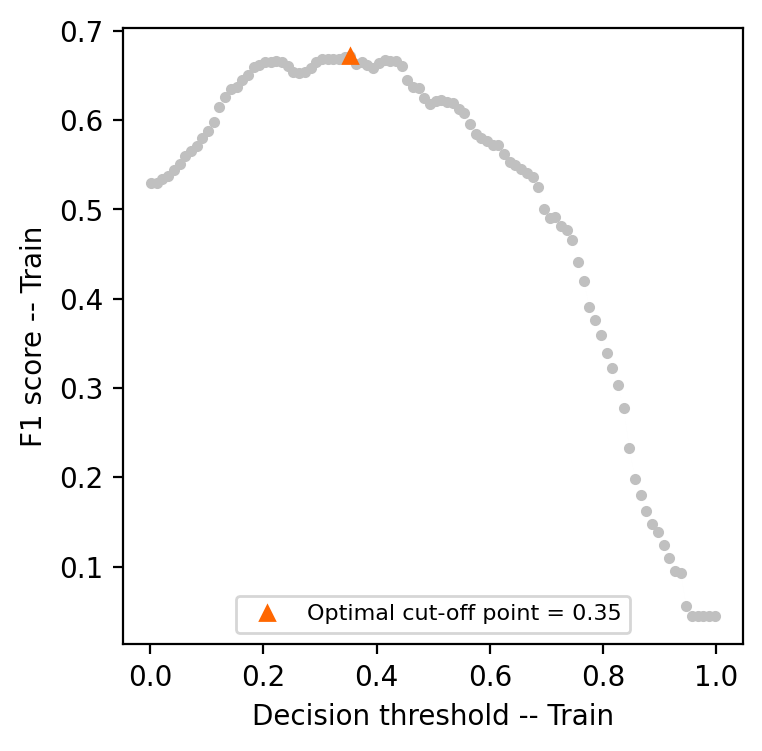

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(
    tuned_model.cv_results_["thresholds"],
    tuned_model.cv_results_["scores"],
    marker="o",
    linewidth=1e-3,
    markersize=3,
    color="#c0c0c0",
)
ax.plot(
    tuned_model.best_threshold_,
    tuned_model.best_score_,
    "^",
    markersize=5,
    color="#ff6700",
    label=f"Optimal cut-off point = {tuned_model.best_threshold_:.2f}",
)
ax.legend(fontsize=8, loc="lower center")
ax.set_xlabel("Decision threshold -- Train", fontsize=10)
ax.set_ylabel("F1 score -- Train", fontsize=10)

We've used the same underlying logistic regression model to evaluate three thresholds. One was the default threshold of 0.5, which is not associated with any business rule. The next threshold, 0.82, is the point where we maximized sensitivity at a 2% false positive rate. Finally, the maximum F1 score is found at a threshold of 0.35.
 

Before starting the model-building process in any machine learning project, it is crucial to work with stakeholders to determine which metric to optimize. Making this decision early ensures that the project aligns with its intended goals.

## Cost-sensitive learning

Cost-sensitive learning is a type of machine learning that considers the cost of various types of misclassification. While it's common in many settings to prioritize precision or recall, cost-sensitive learning assigns a cost to each type of misclassification, which translates model performance to units that stakeholders understand, like dollars saved.

We will use the TELCO customer churn dataset, a binary classification task to demonstrate the value of cost-sensitive learning. The goal is to predict whether a customer will churn or not, given features about the customer's demographics, contract details, and other technical information about the customer's account. The motivation to use this dataset (and some of the code) is from Dan Becker's course on decision threshold optimization.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import TunedThresholdClassifier, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Preprocess the data
data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})
data.drop(columns=["TotalCharges"], inplace=True)

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=["Churn"]), data["Churn"], test_size=0.2, random_state=42
)

Set up a basic pipeline for processing the data and generating predicted probabilities with a random forest model. This will serve as a baseline to compare to the TunedThresholdClassifier.

In [9]:
preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(),
                   selector(dtype_include="object"))],
    remainder="passthrough",
)

original_model = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=42))
original_model.fit(X_train.drop(columns=["customerID"]), y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17c982b50>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

The choice of preprocessing and model type is not important for this tutorial. The company wants to offer discounts to customers who are predicted to churn. During collaboration with stakeholders, you learn that giving a discount to a customer who will not churn (a false positive) would cost $80. You also learn that it's worth $200 to offer a discount to a customer who would have churned. You can represent this relationship in a cost matrix:

In [10]:
def cost_function(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    cost_matrix = np.array([[0, -80], [0, 200]])
    return np.sum(cm * cost_matrix)


cost_scorer = make_scorer(cost_function, neg_label=0, pos_label=1)

We also wrapped the cost function in a scikit-learn custom scorer. This scorer will be used as the objective_metric in the TunedThresholdClassifier and to evaluate profit on the test set.

In [11]:
tuned_model = TunedThresholdClassifier(
    original_model,
    objective_metric=cost_scorer,
    pos_label=1,
    store_cv_results=True,
)

tuned_model.fit(X_train.drop(columns=["customerID"]), y_train)

# Calculate the profit on the test set
original_model_profit = cost_scorer(
    original_model, X_test.drop(columns=["customerID"]), y_test)
tuned_model_profit = cost_scorer(
    tuned_model, X_test.drop(columns=["customerID"]), y_test)

print(f"Original model profit: {original_model_profit}")
print(f"Tuned model profit: {tuned_model_profit}")

Original model profit: 28000
Tuned model profit: 34960


The profit is higher in the tuned model compared to the original. Again, we can plot the objective metric against the decision thresholds to visualize the decision threshold selection on training data:

Text(0.5, 1.0, 'Objective score as a function of the decision threshold')

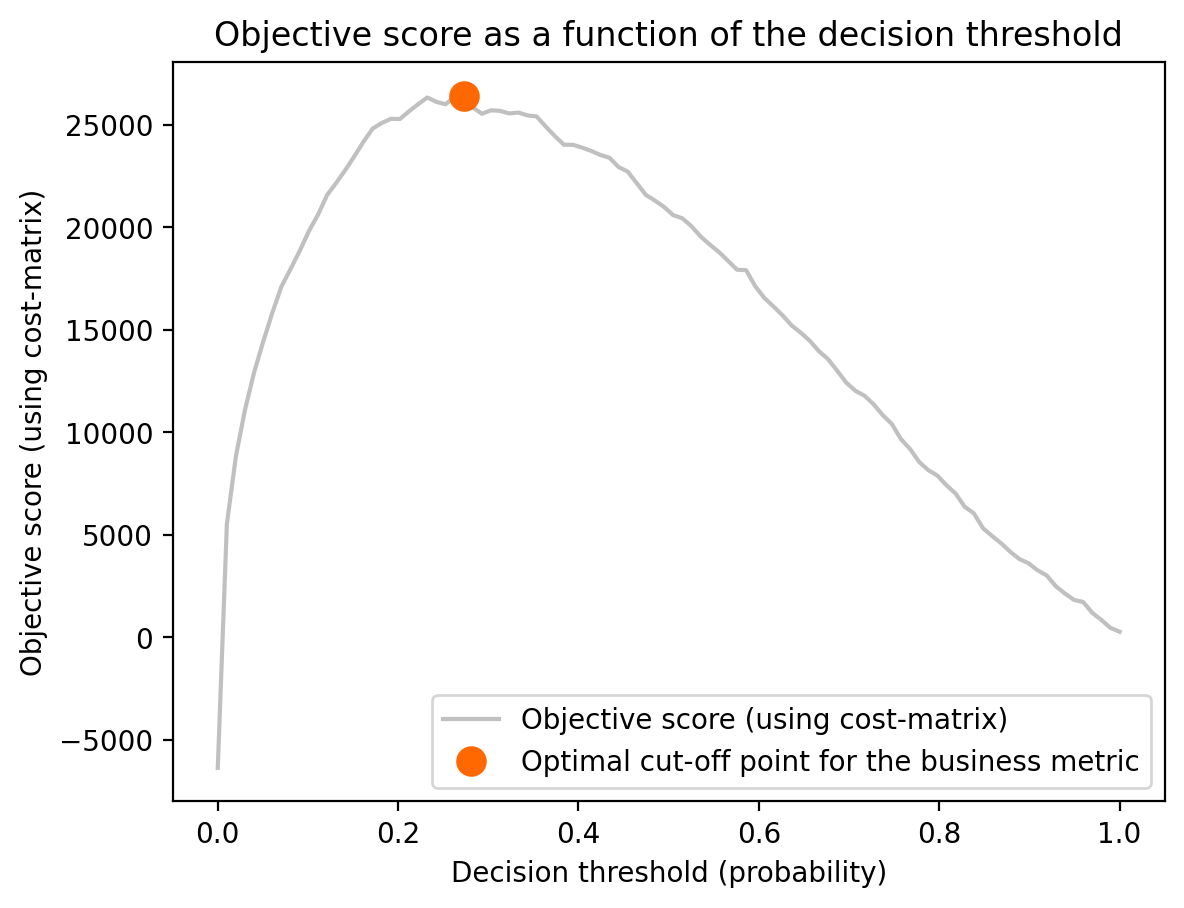

In [12]:
fig, ax = plt.subplots()
ax.plot(
    tuned_model.cv_results_["thresholds"], tuned_model.cv_results_["scores"], color="#c0c0c0", label="Objective score (using cost-matrix)"
)
ax.plot(
    tuned_model.best_threshold_,
    tuned_model.best_score_,
    "o",
    markersize=10,
    color="#ff6700",
    label="Optimal cut-off point for the business metric",
)
ax.legend()
ax.set_xlabel("Decision threshold (probability)")
ax.set_ylabel("Objective score (using cost-matrix)")
ax.set_title("Objective score as a function of the decision threshold")

In reality, assigning a static cost to all instances that are misclassified in the same way is not feasible. There are more advanced methods to tune the threshold by assigning a weight to each instance in the dataset. This is covered in scikit-learn's cost-sensitive learning example.

## Conclusion

The new TunedThresholdClassifier class is a powerful tool. It can help you become a better data scientist by optimizing for metrics that business leaders care about. You learned how to use the new scikit-learn TunedThresholdClassifier class to tune a metric under constraint, maximize a metric, and perform cost-sensitive learning. This tutorial was not intended to be comprehensive or advanced. I wanted to introduce the new feature and highlight its power and flexibility in solving everyday machine learning problems. Please check out the scikit-learn documentation, user guide, and examples for thorough usage examples.

A huge shoutout to [Guillaume Lemaitre](https://github.com/glemaitre) for his work on this feature.

Thanks for reading. Happy tuning. The code for this article is on [GitHub](https://github.com/arvkevi/tunein-blog).